In [1]:
from pathlib import Path

import numpy as np
import polars as pl
from pymoo.problems import get_problem

from desdeo.problem import Evaluator, Objective, Problem, Simulator, Variable, testproblems
from desdeo.problem.testproblems import dtlz2

/Users/bhupindersaini/Projects/DESDEO/desdeo/__init__.py:9: UserWarning: 
            
The following required highly recommended executables cannot be found: bonmin, cbc, ipopt

            DESDEO relies on powerful 3rd party solvers to solve multiobjective
            optimization problems.  Without these solvers, sub-optimal defaults
            will be used instead, which can lead to not optimal, or even wrong,
            results.

            It is highly recommended to have these solvers available
            in the environment DESDEO is utilized!

            For more information, see DESDEO's documentation: https://desdeo.readthedocs.io/en/latest/howtoguides/installing/#third-party-optimizers
            
  _check_executables(required_executables)


In [2]:
# Ignore this mess.


def simulator_problem(problem_name: str, n_vars: int, n_objs: int, server=False) -> Problem:
    # define all the variables separately in DESDEO
    file = "pymoo_simulator.py"
    if server:
        file = r"http://localhost:8000/evaluate"
    variables = [
        Variable(name=f"x_{i+1}", symbol=f"x_{i+1}", variable_type="real", lowerbound=0, upperbound=1)
        for i in range(n_vars)
    ]

    # define all objectives for DESDEO based on the number of objective funcitions
    objectives = [
        Objective(
            name=f"f_{i+1}",
            symbol=f"f_{i+1}",
            simulator_path=Path(f"pymoo_simulator.py"),  # simulator file
            objective_type="simulator",
        )
        for i in range(n_objs)
    ]

    return Problem(
        name="Simulator problem",
        description="",
        variables=variables,
        objectives=objectives,
        simulators=[
            Simulator(
                name="s_1",
                symbol="s_1",
                file=Path(file),
                parameter_options={
                    "name": problem_name,
                    "n_vars": n_vars,
                    "n_objs": n_objs,
                },
            )
        ],
    )

In [ ]:
# Problem details
problem_name = "dtlz2"
n_vars = 10
n_objs = 3

pymoo_native = get_problem(problem_name, n_var=n_vars, n_obj=n_objs)

desdeo_polars = testproblems.dtlz2(n_vars, n_objs)

simulator_script = simulator_problem(problem_name, n_vars, n_objs, False)

simulator_server = simulator_problem(problem_name, n_vars, n_objs, True)

evaluator_polars = Evaluator(
    problem=desdeo_polars,
)
evaluator_script = Evaluator(
    problem=simulator_script,
)
evaluator_server = Evaluator(
    problem=simulator_server,
)

In [18]:
inds = np.random.uniform(low=0, high=1, size=(1000, n_vars))
inds = pl.DataFrame(inds, schema=[f"x_{i+1}" for i in range(n_vars)])

In [19]:
import timeit  # prolly not the best way to time things. but eh.

import matplotlib.pyplot as plt

times = {
    "pymoo_native": timeit.timeit(
        "pymoo_native.evaluate(inds.to_numpy())",
        globals=globals(),
        number=100,
    ),
    "desdeo_polars": timeit.timeit(
        "evaluator_polars.evaluate(xs=inds)",
        globals=globals(),
        number=100,
    ),
    "simulator_server": timeit.timeit(
        "evaluator_server.evaluate(xs=inds.to_dict(as_series=False))",
        globals=globals(),
        number=100,
    ),
    "simulator_script": timeit.timeit(
        "evaluator_script.evaluate(xs=inds.to_dict(as_series=False))",
        globals=globals(),
        number=100,
    ),
}

KeyboardInterrupt: 

In [ ]:
# Normalize the times by pymoo_native
div = times["pymoo_native"]
for key in times:
    times[key] /= div


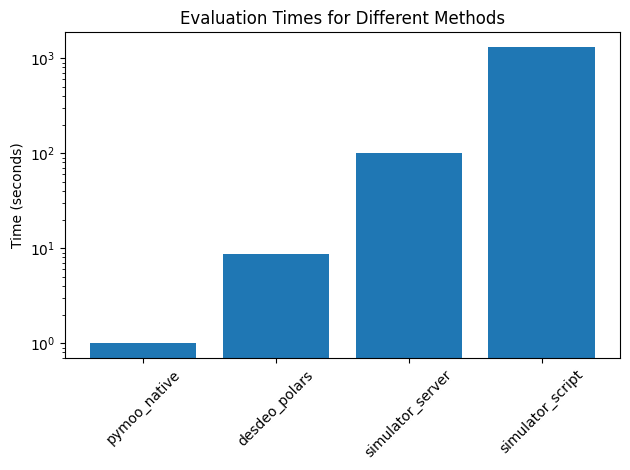

Evaluation times (normalized to pymoo_native):
pymoo_native: 1.0000x
desdeo_polars: 8.7010x
simulator_server: 100.4149x
simulator_script: 1310.6356x


In [ ]:
plt.bar(times.keys(), times.values())
plt.ylabel("Time (seconds)")
plt.title("Evaluation Times for Different Methods")
plt.xticks(rotation=45)
plt.yscale("log")
plt.tight_layout()
plt.show()

print("Evaluation times (normalized to pymoo_native):")
for key, value in times.items():
    print(f"{key}: {value:.4f}x")  # Print the normalized times

In [ ]:
# Note the difference in the output formats:

print("Polars Evaluator output:")
print(evaluator_polars.evaluate(inds.to_dict(as_series=False)))

print("Simulator Script Evaluator output:")
print(evaluator_script.evaluate(inds.to_dict(as_series=False)))

print("Simulator Server Evaluator output:")
print(evaluator_server.evaluate(inds.to_dict(as_series=False)))

Polars Evaluator output:
shape: (1_000, 17)
┌──────────┬──────────┬──────────┬──────────┬───┬──────────┬──────────┬──────────┬──────────┐
│ x_1      ┆ x_2      ┆ x_3      ┆ x_4      ┆ … ┆ f_3      ┆ f_1_min  ┆ f_2_min  ┆ f_3_min  │
│ ---      ┆ ---      ┆ ---      ┆ ---      ┆   ┆ ---      ┆ ---      ┆ ---      ┆ ---      │
│ f64      ┆ f64      ┆ f64      ┆ f64      ┆   ┆ f64      ┆ f64      ┆ f64      ┆ f64      │
╞══════════╪══════════╪══════════╪══════════╪═══╪══════════╪══════════╪══════════╪══════════╡
│ 0.155762 ┆ 0.174976 ┆ 0.804533 ┆ 0.484207 ┆ … ┆ 0.433937 ┆ 1.672795 ┆ 0.471709 ┆ 0.433937 │
│ 0.560605 ┆ 0.324396 ┆ 0.511785 ┆ 0.180045 ┆ … ┆ 1.027173 ┆ 0.740364 ┆ 0.413701 ┆ 1.027173 │
│ 0.235251 ┆ 0.69323  ┆ 0.325533 ┆ 0.233916 ┆ … ┆ 0.612039 ┆ 0.732316 ┆ 1.400236 ┆ 0.612039 │
│ 0.564268 ┆ 0.195951 ┆ 0.124047 ┆ 0.08441  ┆ … ┆ 1.540688 ┆ 1.198178 ┆ 0.380903 ┆ 1.540688 │
│ 0.531167 ┆ 0.390233 ┆ 0.898066 ┆ 0.348194 ┆ … ┆ 1.296644 ┆ 0.961502 ┆ 0.676281 ┆ 1.296644 │
│ …        ┆ …  

In [3]:
from desdeo.emo import nsga3, rvea, EMOEvaluator, SimulatedBinaryCrossover, BoundedPolynomialMutation, RandomGenerator, MaxEvaluationsTerminator, template1
from desdeo.emo.operators.selection import ReferenceVectorOptions, RVEASelector, ParameterAdaptationStrategy, NSGAIII_select
from desdeo.emo.hooks.archivers import NonDominatedArchive

from desdeo.tools.patterns import Publisher

In [10]:
problem_name = "wfg7"
n_vars = 10
n_objs = 4
prob = simulator_problem(problem_name, n_vars=n_vars, n_objs=n_objs, server=True)
publisher = Publisher()

_seed=0

# EMOEvaluator is used to evaluate the solutions
evaluator = EMOEvaluator(
    problem=prob,
    publisher=publisher,
    verbosity=2
)
crossover = SimulatedBinaryCrossover(
    problem=prob,
    publisher=publisher,
    seed=_seed,
    #verbosity=0
)
mutation = BoundedPolynomialMutation(
    problem=prob,
    publisher=publisher,
    #verbosity=0,
    seed=_seed
)
reference_vector_options = ReferenceVectorOptions(
    number_of_vectors=50,
)


selector = RVEASelector(
        problem=prob,
        publisher=publisher,
        reference_vector_options=reference_vector_options,
        verbosity=2,
        parameter_adaptation_strategy=ParameterAdaptationStrategy.FUNCTION_EVALUATION_BASED
    )

selector = NSGAIII_select(
    problem=prob,
    publisher=publisher,
    reference_vector_options=reference_vector_options,
    verbosity=2
)
n_points = selector.reference_vectors.shape[0]
# generate the initial population randomly
generator = RandomGenerator(
    problem=prob,
    evaluator=evaluator,
    publisher=publisher,
    n_points=n_points,
    #verbosity=2,
    seed=_seed
)

#terminator = MaxGenerationsTerminator(max_generations=int(2000/experiment.configuration["pop_size"]), publisher=publisher)
terminator = MaxEvaluationsTerminator(10000, publisher=publisher)


# Register the components to the publisher
components = [evaluator, generator, crossover, mutation, selector, terminator]
[publisher.auto_subscribe(x) for x in components]
[publisher.register_topics(x.provided_topics[x.verbosity], x.__class__.__name__) for x in components]

# Initialize and register any additional components
archive = NonDominatedArchive(problem=prob, publisher=publisher)
publisher.auto_subscribe(archive)
res = template1(
    crossover=crossover,
    mutation=mutation,
    selection=selector,
    generator=generator,
    terminator=terminator,
    evaluator=evaluator,
)

In [9]:
import plotly.express as ex

In [13]:
ex.parallel_coordinates(
    archive.solutions,
    dimensions= [f"f_{i+1}" for i in range(n_objs)],
    )

In [14]:
ex.parallel_coordinates(
    res.outputs
)